Healthcare is an extremely important part of the technological revolution, with deep learning techniques being applied to more and more medical problems.

This dataset for the detection of pneumonia, using chest x-ray images (https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) is used for binary classification (whether the person is normal or has pneumonia).

Used transfer learning from a VGG16 architecture, and after just 5 epochs of training, I was able to achieve >90% accuracy. 

Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 

In [2]:
import os
import shutil
import urllib.request


In [3]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Using TensorFlow backend.


In [4]:
train_data = '../input/chest-xray-pneumonia/chest_xray/train'
test_data = '../input/chest-xray-pneumonia/chest_xray/test'
val_data = '../input/chest-xray-pneumonia/chest_xray/val'

This is the image augmentation part

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    val_data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [7]:
!mkdir ~/.keras
!mkdir ~/.keras/models
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/

mkdir: cannot create directory ‘/root/.keras’: File exists


We specify a constant image size to make things uniform for the model to input. We then input the VGG16 architecture, and ensure it cannot be trained, and that we retain all the weights.

In [8]:
IMAGE_SIZE = [224,224]

vgg = VGG16(input_shape = IMAGE_SIZE + [3],weights= 'imagenet', include_top=False)

We set the already trained parameters to False so that we need not to train again.

In [9]:
for layer in vgg.layers:
    layer.trainable = False

In [10]:
from keras.layers import GlobalAveragePooling2D
result = Flatten()(vgg.output)

In [11]:
# and a fully connected output/classification layer
predictions = Dense(2, activation='softmax')(result)

In [12]:
#Create a model object
model = Model(inputs=vgg.input, outputs=predictions)

In [13]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [14]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [15]:
#fit the model
r = model.fit_generator(train_generator,validation_data=test_generator,
                       epochs=5,
                       steps_per_epoch=len(train_generator),
                       validation_steps=len(test_generator))

Epoch 1/5
163/163 [==============================] - 209s 1s/step - loss: 0.2165 - accuracy: 0.9179 - val_loss: 0.3652 - val_accuracy: 0.9103
Epoch 2/5
163/163 [==============================] - 187s 1s/step - loss: 0.1070 - accuracy: 0.9607 - val_loss: 0.0759 - val_accuracy: 0.9071
Epoch 3/5
163/163 [==============================] - 189s 1s/step - loss: 0.0822 - accuracy: 0.9684 - val_loss: 0.7531 - val_accuracy: 0.9151
Epoch 4/5
163/163 [==============================] - 188s 1s/step - loss: 0.1180 - accuracy: 0.9597 - val_loss: 0.7815 - val_accuracy: 0.9038
Epoch 5/5
163/163 [==============================] - 218s 1s/step - loss: 0.0775 - accuracy: 0.9695 - val_loss: 0.4639 - val_accuracy: 0.9071


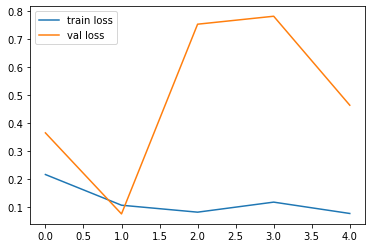

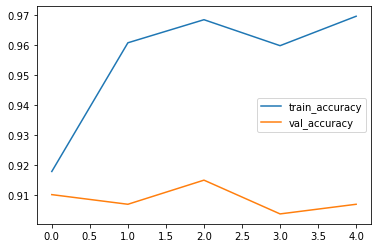

<Figure size 432x288 with 0 Axes>

In [16]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train_accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [17]:
scores = model.evaluate_generator(test_generator)

In [18]:
print(scores)

[0.09981915354728699, 0.9070512652397156]
